In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib.lines import Line2D
from matplotlib.text import Text

Suppose our posterior distribution is a sum of two Beta random variables. Let component 1 be a beta distribution with $a = 2$, $b=5$ and component 2 be a beta distribution with $a=5$ and $b=2$.

The Beta distribution has pdf:

$$f_X(x) = \frac{\Gamma(a+b)x^{a-1}(1-x)^{b-1}}{\Gamma(a)\Gamma(b)}$$

with $0\leq x \leq 1, a>0, b>0$

The respective pdfs of the components are: 

$$\text{Component 1:   } \frac{\Gamma(7)x^{1}(1-x)^{4}}{\Gamma(2)\Gamma(5)}$$

$$\text{Component 2:   } \frac{\Gamma(7)x^{4}(1-x)^{1}}{\Gamma(5)\Gamma(2)}$$

Then the kernel of our posterior could be written as 

$$q(x) = \frac{\Gamma(7)x^{1}(1-x)^{4}}{\Gamma(2)\Gamma(5)} + \frac{\Gamma(7)x^{4}(1-x)^{1}}{\Gamma(5)\Gamma(2)}$$

Note that this is not a legitimate density, the densities are "doubled up" so to speak. We would still need to scale it by the normalising constant by integrating the kernel over the domain of $x$. 

In [50]:
def kernel(x):
    return(beta.pdf(x, 5,2)+beta.pdf(x, 2,5))

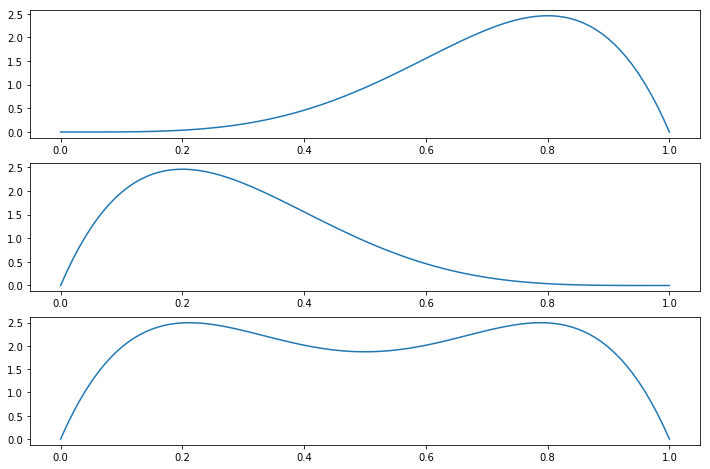

In [35]:
fix, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,8))
x = np.linspace(0, 1, 100)

ax1.plot(x, beta.pdf(x, 5,2))
ax2.plot(x, beta.pdf(x, 2,5))
ax3.plot(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5))

# Rejection sampling

To perform rejection sampling, we would need a candidate density to sample from. Since the domain of our posterior is $[0,1]$ we've chosen another beta distribution with $a=b=1.2$ as our candidate.

Thus our candidate has pdf:

$$g_X(x) = \frac{\Gamma(2.4)x^{0.2}(1-x)^{0.2}}{\Gamma(1.2)\Gamma(1.2)}$$$$

Note that when deciding whether to reject or retain a sample, we need to evaluate the likelihood scaled by a factor $M$ so that $Mg(x) \geq q(x)$. Here we've chosen $M=3$

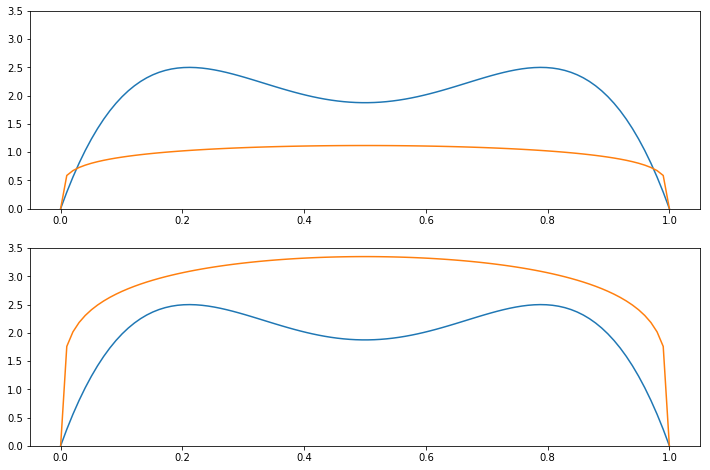

In [42]:
fix, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
x = np.linspace(0, 1, 100)

ax1.set_ylim(0,3.5)
ax2.set_ylim(0,3.5)

#Kernel and candidate density
ax1.plot(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5))
ax1.plot(x, beta.pdf(x,1.2,1.2))

#Kernel and rescaled candidate density
ax2.plot(x, beta.pdf(x, 5,2)+beta.pdf(x, 2, 5))
ax2.plot(x,beta.pdf(x,1.2,1.2)*3)

The first step is to sample from our candidate density and obtain a draw $x^*$ from $g_X(x)$ with $X\sim Beta(a=1.2,b=1.2)$. 

Our sampled point from the candidate density is 0.39169


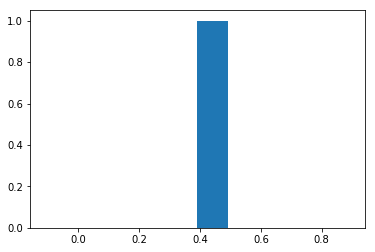

In [43]:
np.random.seed(4)

#Simulating from our candidate
x_star = beta.rvs(a=1.2, b=1.2)

fig, ax = plt.subplots()

ax.hist(x_star)

print("Our sampled point from the candidate density is " + str(np.round(x_star,5)))

The next step is to sample from another uniform distribution, but this time from $U(0,3\times g(0.39169))$ to obtain $u^*$.

In [44]:
np.random.seed(1)
u_star = np.random.uniform(0,3*beta.pdf(x=x_star, a=1.2, b=1.2))

print("Our sampled point from the rejection density is " + str(np.round(u_star,5)))

Our sampled point from the rejection density is 1.38366


<BarContainer object of 1 artists>

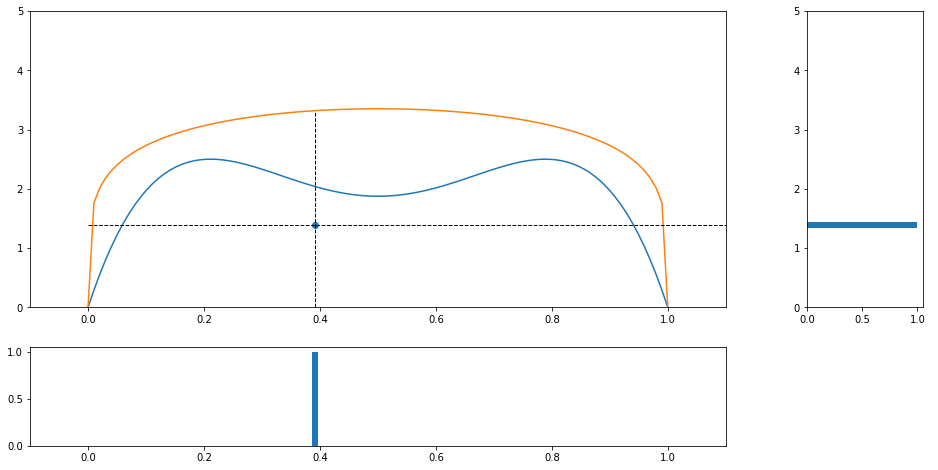

In [47]:
fix, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16,8), gridspec_kw={'height_ratios':[3,1], 'width_ratios':[6,1]})

ax11.set_ylim(0,5)
ax11.set_xlim(-0.1,1.1)
ax21.set_xlim(-0.1,1.1)
ax12.set_ylim(0, 5)
ax22.axis('off')

x = np.linspace(0, 1, 100)

#Kernel and rescaled candidate density
ax11.plot(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5))
ax11.plot(x, 3*beta.pdf(x, a=1.2, b=1.2))

u_line = Line2D([x_star,x_star],[0,3*beta.pdf(x_star, a=1.2, b=1.2)], ls='--', color='black', lw = 1)
ustar_line = Line2D([0,1.5],[u_star,u_star], ls='--', color='black', lw = 1)

ax11.add_artist(u_line)
ax11.add_artist(ustar_line)
ax11.scatter(x_star, u_star)

hist_x = ax21.bar(x_star, height=1, width=0.01)
ax12.barh(u_star, height=0.1, width=1)

Then we accept $x^*$ if the corresponding $u^*$ is less than (or equal to) the pseudo-likelihood of the kernel evaluated at $x^*$

i.e. accept $x^*$ if $u^* \leq q(x^*)$

So then we can break up our rejection density into two regions, one for acceptance when $u^* \leq q(x^*)$ and one for rejection when $u^* > q(x^*)$

<BarContainer object of 1 artists>

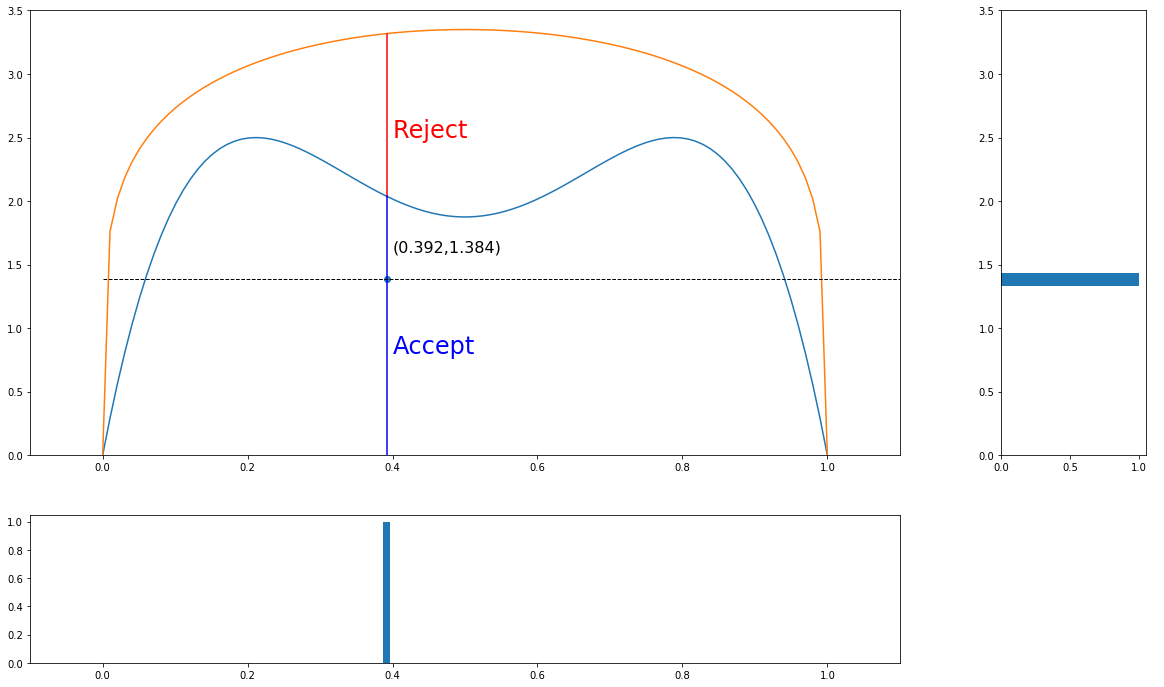

In [65]:
fix, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(20,12), gridspec_kw={'height_ratios':[3,1], 'width_ratios':[6,1]})

ax11.set_ylim(0,3.5)
ax11.set_xlim(-0.1,1.1)
ax21.set_xlim(-0.1,1.1)
ax12.set_ylim(0, 3.5)
ax22.axis('off')

x = np.linspace(0, 1, 100)

#Kernel and rescaled candidate density
ax11.plot(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5))
ax11.plot(x, 3*beta.pdf(x, a=1.2, b=1.2))

rejection_line=Line2D([x_star, x_star],[kernel(x_star), 3*beta.pdf(x_star, a=1.2, b=1.2)], color='red')
acceptance_line=Line2D([x_star, x_star],[0, kernel(x_star)], color='blue')
ustar_line = Line2D([0,1.5],[u_star,u_star], ls='--', color='black', lw = 1)

reject_text = Text(0.4, 2.5, 'Reject', fontsize=24, color='red')
accept_text = Text(0.4, 0.8, 'Accept', fontsize=24, color='blue')
coord_text = Text(0.4, 1.6, '('+str(np.round(x_star, 3))+','+str(np.round(u_star, 3))+')', fontsize=16)

ax11.add_artist(rejection_line)
ax11.add_artist(acceptance_line)
ax11.add_artist(reject_text)
ax11.add_artist(accept_text)
ax11.add_artist(coord_text)
ax11.add_artist(ustar_line)
ax11.scatter(x_star, u_star)

hist_x = ax21.bar(x_star, height=1, width=0.01)
ax12.barh(u_star, height=0.1, width=1)

Note that the rejection region changes depending on the $x^*$ sampled, because the corresponding $q(x^*)$ and $Mg(x^*)$ will have changed as well. If we were to map out all rejection regions across all $x^*$, this is what it would look like.

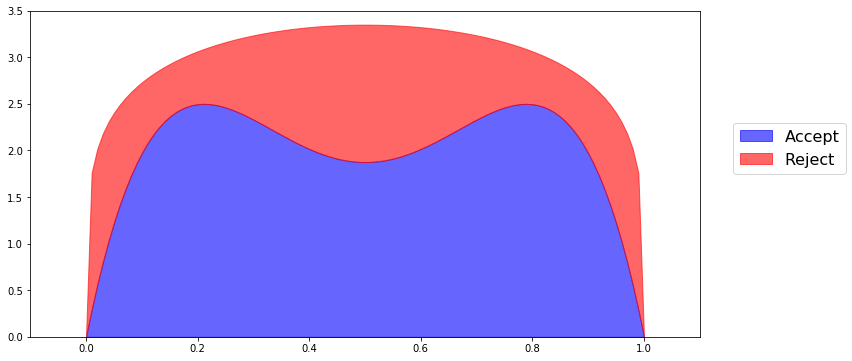

In [63]:
fix, ax = plt.subplots(figsize=(12,6))

ax.set_ylim(0,3.5)
ax.set_xlim(-0.1,1.1)

x = np.linspace(0, 1, 100)

#Kernel and rescaled candidate density
#ax.plot(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5))
#ax.plot(x, 3*beta.pdf(x, 1.2, 1.2))
ax.fill_between(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5), color='blue', alpha=0.6, label= 'Accept')
ax.fill_between(x, beta.pdf(x, 5,2)+beta.pdf(x, 2,5), 3*beta.pdf(x, 1.2, 1.2), color='red', alpha=0.6, label= 'Reject')

ax.legend(loc=(1.05,0.5), fontsize=16)


Does the choice of candidate density matter?

In theory no, in practice yes. While sampling is very cheap, it isn't free, we still want to be as efficient with our sampling as possible. So we want to choose a candidate that mimics the shape of our kernel as closely as possible.

This becomes particularly problematic in higher dimensions due to the curse of dimensionality, the probability of accepting a candidate decreases exponentially with the number of dimensions. Intuitively, this is because you are multiplying a sequence of probabilities together (probability of acceptance for each dimension). The more probabilities you multiply together, the smaller the resulting probability.

## An example 

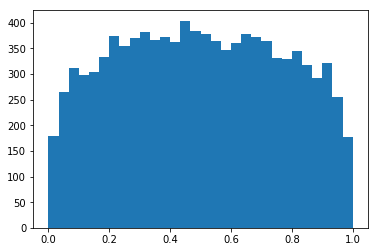

In [75]:
#sampling x_stars from our candidate distribution

x_stars = beta.rvs(a=1.2, b=1.2, size=10000)

fig, ax = plt.subplots()

hist = ax.hist(x_stars, bins=30)

In [72]:
#Generating u_stars
M = 3

#Generating u_star for each x_star
u_stars = np.random.uniform(0,M*beta.pdf(x_stars,a=1.2,b=1.2))

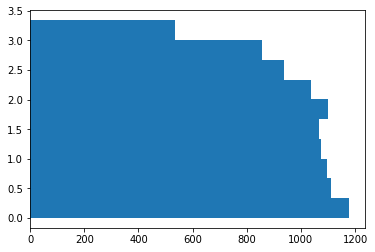

In [73]:
temp = plt.hist(u_stars, orientation='horizontal')

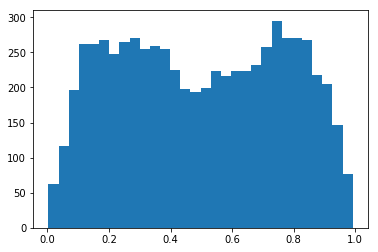

In [74]:
#Accepting based on criteria
accept = u_stars <= kernel(x_stars)
accepted = x_stars[accept]

#Plotting the histogram
temp = plt.hist(accepted, bins=30)

# Importance sampling

Suppose we wanted to estimate the expected value of some function of our posterior, say $h(X)=X^2 => E[h(X)]=E[X^2]$. We could use our draws obtained from rejection sampling and simply estimate $$\frac{1}{N}\Sigma^N_{i=1}h(x_i)$$

In [96]:
print('The expected value of the function of our posterior is ' + str(np.round(np.mean(accepted**2),5)))

The expected value of the function of our posterior is 0.31978


Importance sampling is an alternative way to achieve this goal too. Recall that the formula for importance sampling is

$$\large{\frac{\frac{1}{N}\Sigma^N_{i=1}h(x_i)\frac{q(x_i)}{g(x_i)}}{\frac{1}{N}\Sigma^N_{i=1}\frac{q(x_i)}{g(x_i)}}}
=\large{\frac{\frac{1}{N}\Sigma^N_{i=1}h(x_i)w(x_i)}{\frac{1}{N}\Sigma^N_{i=1}w(x_i)}}$$

where

$$\large{w(x_i)=\frac{q(x_i)}{g(x_i}}$$

The first step is to sample from our candidate to obtain $x_i,\ i=1,2,..,N$ and $g(x_i),\ i=1,2,..,N$.

We'll use back the same candidate we had earlier $Beta(a=1.2, b=1.2)$

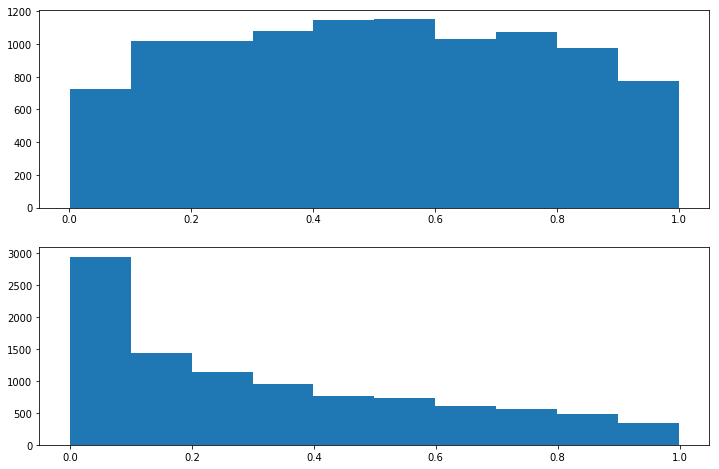

In [90]:
#sampling x
x = beta.rvs(a=1.2, b=1.2, size=10000)

#evaluationg our function
h = x**2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

temp = ax1.hist(x)
temp = ax2.hist(h)

Next we calculate the weights $w(x_i) = q(x_i)/g(x_i)$

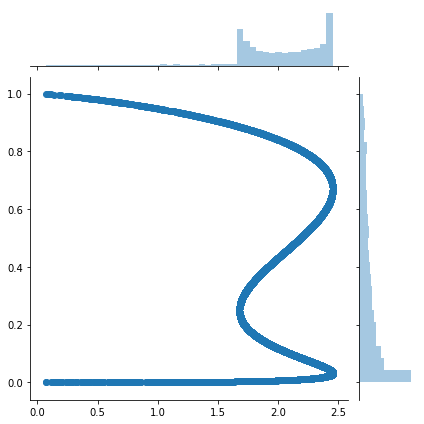

In [94]:
import seaborn as sns

weights = kernel(x)/beta.pdf(x, a=1.2, b=1.2)

sns.jointplot(weights, h)

Then to calculate our desired expectation we multiply the weights with the $x$s passed through $h$, add them together and divide by the sum of the weights.

In [97]:
E_h = np.sum(h*weights)/np.sum(weights)

print('The expected value of the function of our posterior is ' + str(np.round(E_h,5)))

The expected value of the function of our posterior is 0.32193
